In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import itertools
import os


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('seaborn-whitegrid')

# 전처리 및 머신 러닝 알고리즘
from sklearn.preprocessing import StandardScaler

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score

from pandas_profiling import ProfileReport
from datetime import datetime


# 경고 제거 (판다스가 에러 메세지를 자주 만들어 내기 때문에 이를 일단 무시하도록 설정합니다.)
import sys
import warnings

import warnings
warnings.filterwarnings('ignore')
#mpl.style.use('ggplot')
#pylab.rcParams['figure.figsize'] = 12,8
sns.set_style('white')

## Methods and scores
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score


In [4]:
# Dataset initial steps...
dataset_10k = pd.read_csv(
    "../../../input/customers/customer_segmentation_10k.csv"
)
dataset_10k.last_order = pd.to_datetime(dataset_10k.last_order)
min_date = dataset_10k.last_order.min()
dataset_10k.last_order = dataset_10k.last_order.apply(lambda x: (x - min_date).days)

print(f"Number of Data points: {dataset_10k.shape[0]}")

dataset_10k.head()

Number of Data points: 10000


,customer_id,qtt_order,total_spent,last_order
0,0,370,189719.04,337
1,1,48,159092.71,215
2,2,4,28239.30,267
3,3,157,378630.99,215
4,4,16,84763.20,112


In [5]:
dataset_10k.describe()

,customer_id,qtt_order,total_spent,last_order
count,10000.00000,10000.000000,1.000000e+04,10000.000000
mean,4999.50000,102.776800,2.265200e+05,193.449700
std,2886.89568,135.589727,2.526256e+05,92.044942
min,0.00000,0.000000,8.330200e+02,0.000000
25%,2499.75000,25.000000,6.339747e+04,117.000000
50%,4999.50000,54.000000,1.382156e+05,187.000000
75%,7499.25000,118.000000,2.888532e+05,272.000000
max,9999.00000,1274.000000,2.181515e+06,407.000000


In [6]:
ProfileReport(dataset_10k, title='Dataset', minimal=True, progress_bar=False, 
              samples=None, correlations=None, interactions=None, explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}},
              html={'style':{'primary_color': '#219EBC'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

**About the columns**

* qqt_order: Total of order for the customers (frequency)
* total_spent: Total spent for the customer summing all orders (monetary)
* last_order: Customer last order DateTime (recency).

## **Metrics: 실루엣 & 엘보우**

**실루엣 계수에 대하여**
<br>
<br>
resources: 
[link1](https://romg2.github.io/mlguide/17_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-07.-%EA%B5%B0%EC%A7%91%ED%99%94-%EA%B5%B0%EC%A7%91-%ED%8F%89%EA%B0%80/)
[link2](https://m.blog.naver.com/samsjang/221017639342)
<br>
* 실루엣 기법이란, 최대한 cohesion (클러스터 내의 밀집도를)을 높이면서 separation (다른 클러스터와 최대한 거리를)을 높이는 방법

![image1](./silhouette_formula.jpg)

* 전체 실루엣 계수 평균이 높다고 반드시 최적의 군집 개수로 군집화가 잘 되었다고 볼 수 없다. 특정 군집만 실루엣 계수가 높고 다른 군집은 내부 데이터끼리 거리가 멀어 계수가 낮아도 전체 평균은 높을 수 있기 때문이다.


In [7]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [19]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*','8','p','P','+','X','D','1','2','3','4']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

**엘보우 기법에 대하여**
<br>
<br>
resources: 
[link1](https://m.blog.naver.com/samsjang/221017639342)
[link2]()
<br>
* k-means에서는 Sum of Squared Error(SSE)의 값이 최소화 되도록 클러스터의 중심을 찾는데, k값을 늘려가면서 SSE가 급격하게 줄어들다가 더이상 잘 안줄어드는 팔꿈치같은 점을 엘보우 포인트라고한다. 


In [20]:
def elbow(X, xtitle='number of clusters', ytitle='Sum of Sqaured Error'):
    sse = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=10)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.show()


In [21]:
dataset_10k.columns

Index(['customer_id', 'qtt_order', 'total_spent', 'last_order'], dtype='object')

In [22]:
dataset = dataset_10k.drop('customer_id', axis=1)
# print(dataset_10k.head())
print(dataset.head())
x_labels = ['qtt_order','total_spent', 'last_order']
y_labels = ['cluster']


   qtt_order  total_spent  last_order
0        370    189719.04         337
1         48    159092.71         215
2          4     28239.30         267
3        157    378630.99         215
4         16     84763.20         112


## **Method 1: k-Means Clustering**


In [23]:

kmeans_data = dataset.copy()

# kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=30, random_state=10)
# kmeans.fit(kmeans_data)
# kmeans_data['cluster'] = kmeans.labels_
# score_samples = silhouette_samples(kmeans_data[x_labels], kmeans_data[y_labels])
# print(f'silhouette_samples( ) return 값의 shape: {score_samples.shape}')

# # 데이터 프레임에 실루엣 계수 추가
# kmeans_data['silhouette_coeff'] = score_samples

# # 모든 데이터의 평균 실루엣 계수
# average_score = silhouette_score(kmeans_data[x_labels], kmeans_data.cluster)
# print(f'붓꽃 데이터셋 Silhouette Analysis Score: {average_score:.3f}')

In [24]:
kmeans_data.describe()

,qtt_order,total_spent,last_order
count,10000.000000,1.000000e+04,10000.000000
mean,102.776800,2.265200e+05,193.449700
std,135.589727,2.526256e+05,92.044942
min,0.000000,8.330200e+02,0.000000
25%,25.000000,6.339747e+04,117.000000
50%,54.000000,1.382156e+05,187.000000
75%,118.000000,2.888532e+05,272.000000
max,1274.000000,2.181515e+06,407.000000


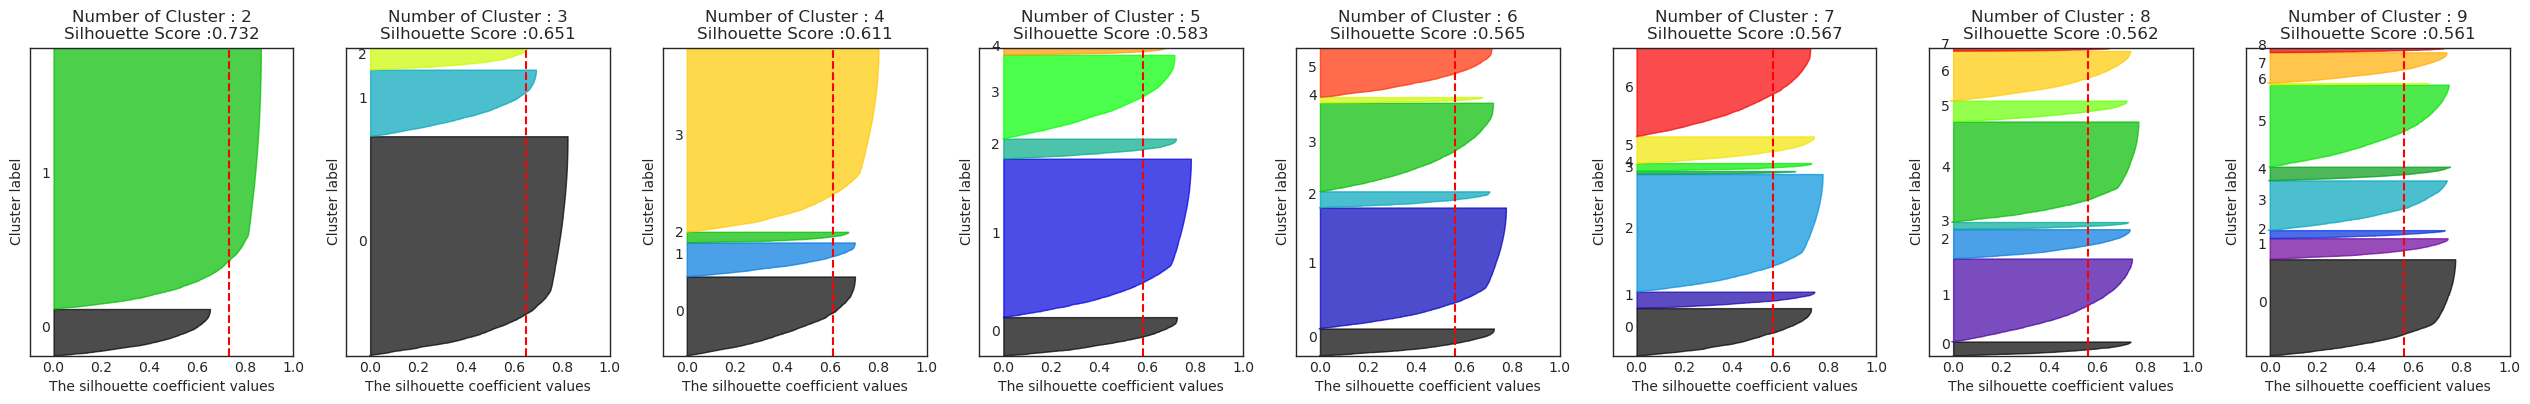

In [25]:
visualize_silhouette(range(2,10), kmeans_data)

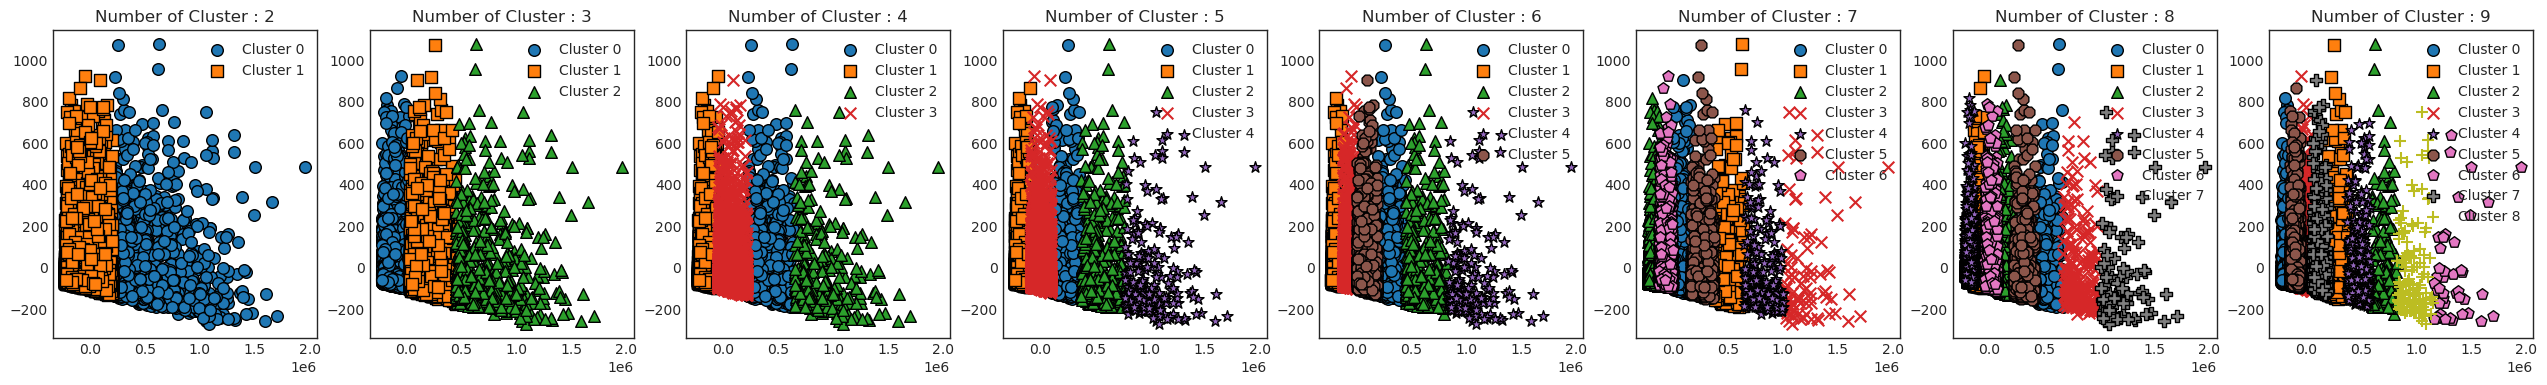

In [26]:
visualize_kmeans_plot_multi(range(2,10), kmeans_data)

* 실루엣 스코어 (빨간 점선)을 기준으로 오른쪽으로 많이 넘어가는 cluster가 많을수록 좋다는 것을 알았다. 이런 판단기준을 가지고는 클러스터는 최적이 되는게 4개 혹은 5개가 되지 않을까 싶다.
* kmeans plot은 이걸 통해서 어떻게 이해해야하는지 잘 모르겠음

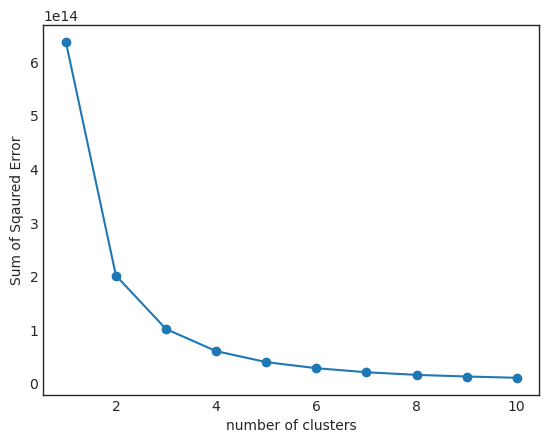

In [28]:
elbow(kmeans_data)


* 엘보우 포인트가 2,3,4 중에 하나가 되는게 맞는 것 같다.
* 단점
    * 정확히 뭐가 좋을지는 직감에 맡길 수 밖에 없는 것 같다. 


## **Method 2: DBSCAN**


In [67]:
dbscan_data = dataset.copy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dbscan_data)
dbscan = DBSCAN()
dbscan.fit(scaled_data)
# dbscan.labels_.shape
dbscan_data['cluster'] = dbscan.labels_
dbscan_data.head()
dbscan_data.groupby(['cluster']).mean()
print(dbscan_data['cluster'].nunique() -1)




6


In [48]:
# silhouette_score(dbscan_data,dbscan.labels_)

In [58]:
def visualize_silhouette_dbscan(eps_lists, X_features):
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import DBSCAN
    from sklearn.metrics import silhouette_samples, silhouette_score
    from sklearn.preprocessing import StandardScaler

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(eps_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)


    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, eps_i in enumerate(eps_lists):
        
        # scale the data
        scaler = StandardScaler()
        data = scaler.fit_transform(X_features)

        # DBSCAN 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        dbscan = DBSCAN(eps = eps_i)
        dbscan.fit(data)
        try:
            sil_avg = silhouette_score(data, dbscan.labels_)
            sil_values = silhouette_samples(data, dbscan.labels_)
        except:
            print("only one cluster!")
            break
        
        print(f"sil_avg: {sil_avg}")
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(eps_i)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (eps_i + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cols):
            ith_cluster_sil_values = sil_values[dbscan.labels_==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / eps_i)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

sil_avg: 0.1633410231142201
sil_avg: 0.5648960654432763
sil_avg: 0.7001198605579657
sil_avg: 0.7313766816692517
sil_avg: 0.7504454948090502
only one cluster!


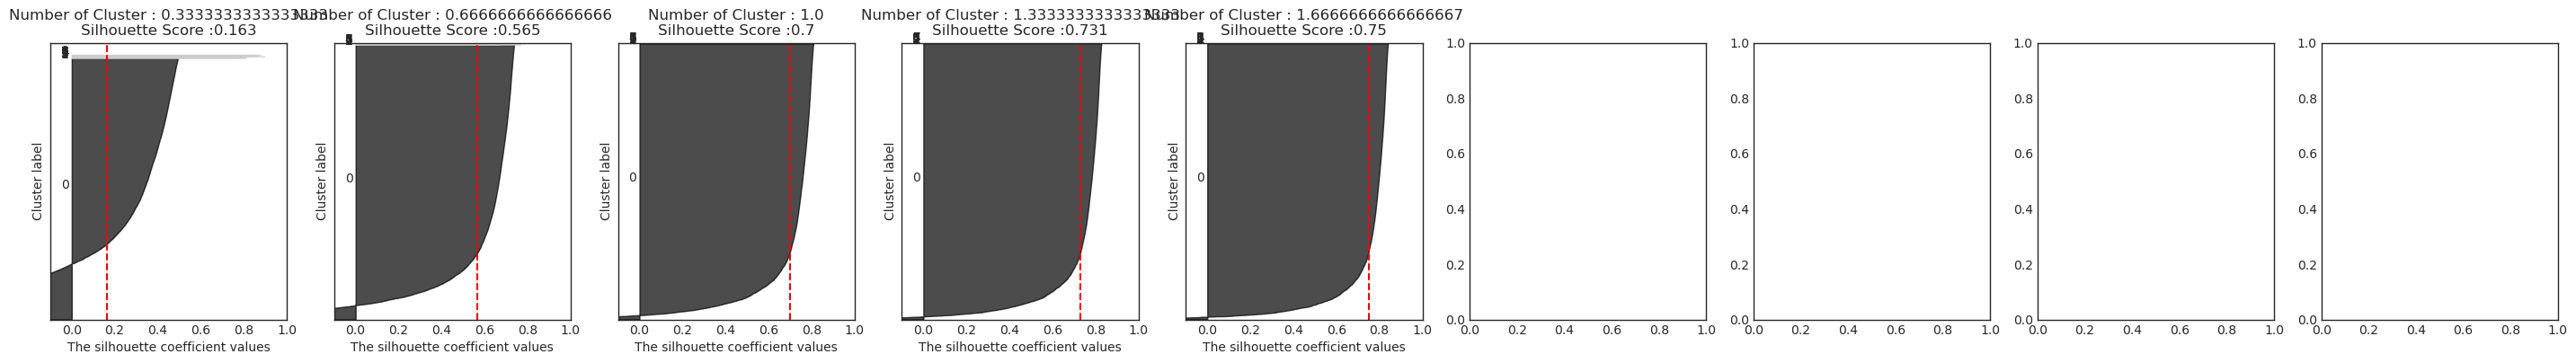

In [59]:
visualize_silhouette_dbscan([i/3 for i in range(1,10)], dbscan_data)


In [61]:
def elbow(X, xtitle='number of clusters', ytitle='Sum of Sqaured Error'):
    sse = []
    eps_s = [i/4 for i in range(1,20)]
    
    for eps_i in eps_s:
        newX = StandardScaler.fit_transform(X)
        dbscan = DBSCAN(eps=eps_i)
        dbscan.fit(newX)
        dbscan.labels_
        # kmeans = KMeans(n_clusters=i, init='k-means++', random_state=10)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.show()

elbow(dbscan_data, xtitle='maximum dist b/w neighbors')

TypeError: elbow() got an unexpected keyword argument 'xtitle'